In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from math import radians, sin, cos, sqrt, asin
from sqlalchemy import create_engine
import pymysql
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.use('Agg')

EARTH_RADIUS = 6371.0  # 지구 반지름 km

def haversine(lat1, lon1, lat2, lon2):
    """두 좌표 간 대원거리(km) 계산"""
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * EARTH_RADIUS * asin(sqrt(a))

In [2]:

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 2) MySQL 데이터베이스 연결
host = 'localhost'
user = 'root'
password = '0000'
database = 'df_region'
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

# 3) 테이블 불러오기
table_busy = 'busy_table'
df_busy = pd.read_sql(table_busy, con=engine)


In [3]:
df_busy

,시도,시군구,읍면동,시간대,혼잡도,z_score,min_max,fixed_level,quantile_level,final_level,latitude,longitude
0,경기도,가평군,가평읍,00시,408.375000,-0.290630,0.311725,보통,여유,여유,37.825364,127.516539
1,경기도,가평군,가평읍,01시,112.416667,-0.084662,0.498607,보통,보통,보통,37.825364,127.516539
2,경기도,가평군,가평읍,02시,66.208333,0.218280,0.677755,붐빔,붐빔,붐빔,37.825364,127.516539
3,경기도,가평군,가평읍,03시,6.916667,0.070654,0.661022,붐빔,붐빔,붐빔,37.825364,127.516539
4,경기도,가평군,가평읍,04시,-94.708333,0.247461,0.735938,붐빔,붐빔,붐빔,37.825364,127.516539
...,...,...,...,...,...,...,...,...,...,...,...,...
30931,인천광역시,중구,해안동3가,19시,22.041667,-0.182652,0.643921,보통,붐빔,붐빔,37.471410,126.622168
30932,인천광역시,중구,해안동3가,20시,43.750000,-0.034822,0.742341,보통,붐빔,붐빔,37.471410,126.622168
30933,인천광역시,중구,해안동3가,21시,-20.083333,-0.012757,0.770124,보통,매우 붐빔,붐빔,37.471410,126.622168
30934,인천광역시,중구,해안동3가,22시,14.500000,-0.078088,0.738980,보통,붐빔,붐빔,37.471410,126.622168


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class PopularityScorer:
    def __init__(self, review_data):
        """리뷰 데이터 로딩"""
        self.review_data = review_data.copy()
        self.dong_cate_stats = None
        self.scaled_df = None
        self.weights = None

    def calculate_positive_probability(self, row):
        """감정레이블에 따라 긍정확률 계산"""
        if row["감정레이블"] == 2:
            return row["감정확률"]
        elif row["감정레이블"] == 0:
            return 1 - row["감정확률"]
        else:
            return 0.5

    def aggregate_features(self):
        """리뷰수, 평균별점, 평균긍정비율 집계 및 로그리뷰수 추가"""
        self.review_data["긍정확률"] = self.review_data.apply(self.calculate_positive_probability, axis=1)

        stats = self.review_data.groupby(["행정구", "행정동", "카테고리"]).agg(
            리뷰수=("별점", "count"),
            평균별점=("별점", "mean"),
            평균긍정비율=("긍정확률", "mean")
        ).reset_index()

        stats["로그리뷰수"] = np.log1p(stats["리뷰수"])
        self.dong_cate_stats = stats

    def bayesian_adjust(self, value, count, global_mean, m):
        """베이지안 보정"""
        return (count * value + m * global_mean) / (count + m)

    def apply_bayesian_correction(self):
        """평균별점과 평균긍정비율 베이지안 보정"""
        global_avg_rating = self.dong_cate_stats["평균별점"].mean()
        global_avg_posrate = self.dong_cate_stats["평균긍정비율"].mean()
        m_rating = self.dong_cate_stats["리뷰수"].median()
        m_posrate = self.dong_cate_stats["리뷰수"].median()

        self.dong_cate_stats["보정평균별점"] = self.dong_cate_stats.apply(
            lambda row: self.bayesian_adjust(row["평균별점"], row["리뷰수"], global_avg_rating, m_rating), axis=1
        )
        self.dong_cate_stats["보정평균긍정비율"] = self.dong_cate_stats.apply(
            lambda row: self.bayesian_adjust(row["평균긍정비율"], row["리뷰수"], global_avg_posrate, m_posrate), axis=1
        )

    def scale_features(self):
        """MinMaxScaler로 표준화"""
        features = ["로그리뷰수", "보정평균별점", "보정평균긍정비율"]
        scaler = MinMaxScaler()
        self.scaled_df = pd.DataFrame(
            scaler.fit_transform(self.dong_cate_stats[features]),
            columns=features
        )

    def assign_equal_weights(self):
        """단순평균 가중치 부여 (각 1/3)"""
        n_features = self.scaled_df.shape[1]
        self.weights = {col: 1/n_features for col in self.scaled_df.columns}

    def calculate_popularity_score(self):
        """최종 인기도지수 계산"""
        score = sum(
            self.weights[col] * self.scaled_df[col]
            for col in self.scaled_df.columns
        )
        self.dong_cate_stats["인기도지수"] = score

    def run(self):
        """전체 프로세스 실행"""
        self.aggregate_features()
        self.apply_bayesian_correction()
        self.scale_features()
        self.assign_equal_weights()
        self.calculate_popularity_score()
        return self.dong_cate_stats.sort_values(by="인기도지수", ascending=False).reset_index(drop=True)

In [5]:

import pandas as pd

file_review = r"E:\machin-prj\EDA\popularity_fianl\zb_review_data_final.csv"
# 1. 데이터 불러오기
reviews = pd.read_csv(file_review, encoding="utf-8-sig")

# 2. 클래스 인스턴스화
scorer = PopularityScorer(reviews)

# 3. 파이프라인 실행
dong_cate_stats = scorer.run()

# 4. 결과 확인
dong_cate_stats.head(10)

# 5. 결과 저

,행정구,행정동,카테고리,리뷰수,평균별점,평균긍정비율,로그리뷰수,보정평균별점,보정평균긍정비율,인기도지수
0,서울 중구,종로1·2·3·4가동,음식,56,4.732143,0.911946,4.043051,4.536986,0.850754,0.813807
1,서울 마포구,반포4동,음식,40,4.925000,0.936527,3.713572,4.616154,0.850826,0.807700
2,경기 부천시,원종1동,음식,40,4.900000,0.921234,3.713572,4.598913,0.840280,0.794916
3,경기 파주시,교하동,힐링,48,4.875000,0.889881,3.891820,4.617226,0.827290,0.792548
4,서울 강남구,압구정동,문화,82,4.719512,0.839205,4.418841,4.577369,0.807016,0.792465
5,서울 노원구,상계5동,음식,40,4.775000,0.914301,3.713572,4.512706,0.835498,0.779573
6,경기 성남시,단대동,음식,51,4.568627,0.895347,3.951244,4.401984,0.834051,0.776035
7,경기 과천시,문원동,음식,61,4.622951,0.861874,4.127134,4.465024,0.815964,0.773837
8,서울 성북구,명동,음식,35,4.914286,0.907648,3.583519,4.579942,0.823670,0.769535
9,경기 연천군,연천읍,음식,118,4.483051,0.794936,4.779123,4.409830,0.777127,0.759084


In [6]:
df_trip_merged = 'trip_merged'

df_tourism2 = pd.read_sql(df_trip_merged, con=engine)

df_tourism2

,자치구,행정동,힐링,액티비티,문화,음식,쇼핑,숙박,체험다양성_엔트로피,체험다양성_표준편차,위도,경도
0,가평군,가평읍,8.876844,35.535411,8.340898,32.220430,0.889715,0.000000,1.241378,15.629019,37.828841,127.487514
1,가평군,북면,16.513754,39.817658,9.000000,5.884205,0.060781,0.000000,1.137316,15.013705,37.944531,127.494107
2,가평군,상면,6.450964,25.268229,3.985214,17.605723,0.133293,0.000000,1.183715,10.294914,37.790769,127.337749
3,가평군,설악면,8.757376,47.974015,4.162964,28.523809,0.939065,0.000000,1.115577,19.231637,37.653347,127.499130
4,가평군,조종면,2.879345,20.849044,3.314121,16.775161,0.733022,0.058038,1.169467,8.991628,37.867121,127.371755
...,...,...,...,...,...,...,...,...,...,...,...,...
1219,중구,영종1동,1.378579,1.261023,1.519679,4.880436,0.436482,NaN,1.325857,1.721161,37.486842,126.558114
1220,중구,영종2동,1.337295,1.182559,1.417489,4.793340,0.437261,NaN,1.317795,1.699496,37.495635,126.569286
1221,중구,영종동,2.213174,2.429071,1.643989,5.732951,0.347635,NaN,1.352629,1.993813,37.509083,126.534678
1222,중구,용유동,23.811770,11.947058,2.922033,37.514162,0.000000,NaN,1.127921,15.527773,37.433622,126.407745


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pandas.plotting import scatter_matrix

%matplotlib inline


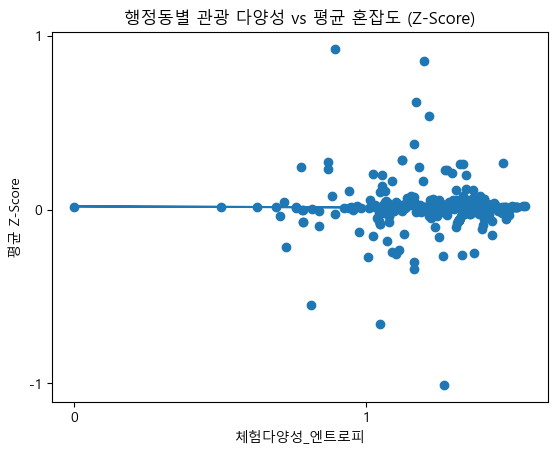

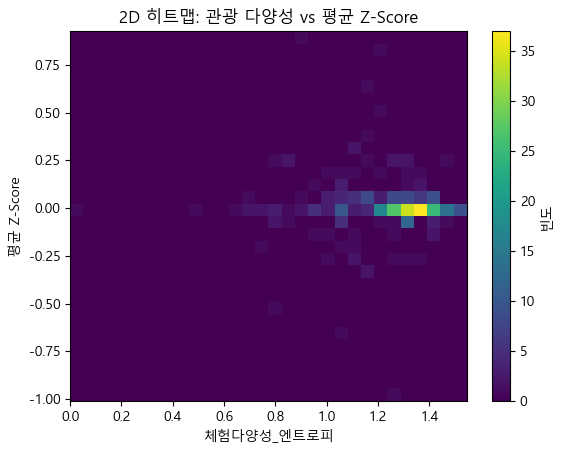

In [8]:
# 1. Prepare aggregated busy data by administrative dong
df_busy['key'] = df_busy['시군구'] + ' ' + df_busy['읍면동']
mapping = {'여유': 1, '보통': 2, '붐빔': 3, '매우 붐빔': 4}
df_busy['final_level_num'] = df_busy['final_level'].map(mapping)
busy_agg = df_busy.groupby('key').agg({
    '혼잡도': 'mean',
    'z_score': 'mean',
    'final_level_num': 'mean'
}).rename(columns={'혼잡도': 'mean_busy', 'z_score': 'mean_z_score', 'final_level_num': 'mean_final_level'}).reset_index()

# Merge with tourism diversity
df_tourism2['key'] = df_tourism2['자치구'] + ' ' + df_tourism2['행정동']
tourism = df_tourism2[['key', '체험다양성_엔트로피', '체험다양성_표준편차']]

busy_tour = pd.merge(busy_agg, tourism, on='key', how='inner')

# Scatter with trend line: mean_z_score vs entropy
x = busy_tour['체험다양성_엔트로피']
y = busy_tour['mean_z_score']
coeffs = np.polyfit(x, y, deg=1)
trend = np.polyval(coeffs, x)

plt.figure()
plt.scatter(x, y)
plt.plot(x, trend)
plt.xlabel('체험다양성_엔트로피')
plt.ylabel('평균 Z-Score')
plt.title('행정동별 관광 다양성 vs 평균 혼잡도 (Z-Score)')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# 2D heatmap
plt.figure()
plt.hist2d(x, y, bins=30)
plt.colorbar(label='빈도')
plt.xlabel('체험다양성_엔트로피')
plt.ylabel('평균 Z-Score')
plt.title('2D 히트맵: 관광 다양성 vs 평균 Z-Score')
plt.show()


In [9]:
busy_agg

,key,mean_busy,mean_z_score,mean_final_level
0,가평군 가평읍,-38.130208,0.044334,2.458333
1,가평군 북면,-20.979167,0.014774,2.500000
2,가평군 상면,60.262153,0.027389,2.541667
3,가평군 설악면,-82.387153,0.024982,2.583333
4,가평군 조종면,-11.744792,0.039066,2.541667
...,...,...,...,...
1284,화성시 진안동,-486.395833,0.116583,2.583333
1285,화성시 청계동,-813.777777,-0.041214,2.458333
1286,화성시 팔탄면,-320.803819,-0.021381,2.416667
1287,화성시 향남읍,150.927083,0.033606,2.500000


In [10]:
import re
# 2) key 생성 및 정제: 시군구 + 읍면동 기준
df_busy['key'] = df_busy['시군구'] + ' ' + df_busy['읍면동']

# df_tourism2: '자치구 행정동'
df_tourism2['key'] = df_tourism2['자치구'] + ' ' + df_tourism2['행정동']

# dong_cate_stat: '행정구'에서 마지막 단어(구)만 추출 + '행정동'
dong_cate_stats['key'] = (
    dong_cate_stats['행정구'].str.split().str[-1] + ' ' +
    dong_cate_stats['행정동']
)

# 공백/다중 공백 정리
def clean_key(x):
    return re.sub(r'\s+', ' ', x.strip())

for df in (df_busy, df_tourism2, dong_cate_stats):
    df['key'] = df['key'].apply(clean_key)

# 3) df_busy: final_level 숫자 매핑 및 평균 계산
level_map = {'여유':1, '보통':2, '붐빔':3, '매우 붐빔':4}
df_busy['level_num'] = df_busy['final_level'].map(level_map)

busy_agg = df_busy.groupby('key')['level_num'] \
                  .mean() \
                  .reset_index(name='mean_level')

# 4) merge for pop_busy
pop_busy = pd.merge(
    busy_agg,
    dong_cate_stats[['key','인기도지수']],
    on='key',
    how='inner'
)

# 5) merge for busy_tour
tourism = df_tourism2[['key','체험다양성_엔트로피','체험다양성_표준편차']]
busy_tour = pd.merge(busy_agg, tourism, on='key', how='inner')

# 6) 상태 확인
print("busy_agg:", busy_agg.shape)
print("busy_tour:", busy_tour.shape)
print("pop_busy:", pop_busy.shape)



busy_agg: (1289, 2)
busy_tour: (332, 4)
pop_busy: (1059, 3)


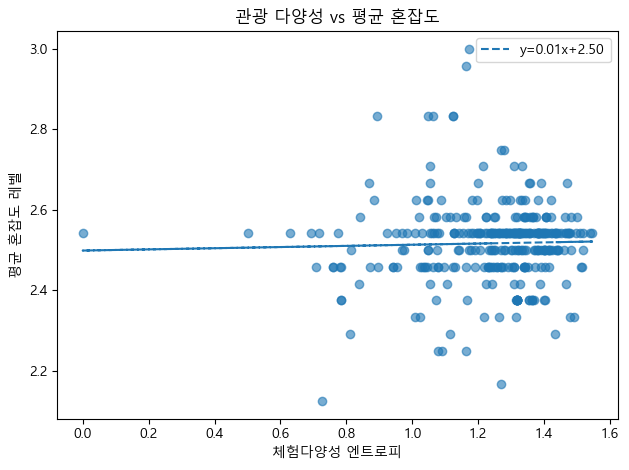

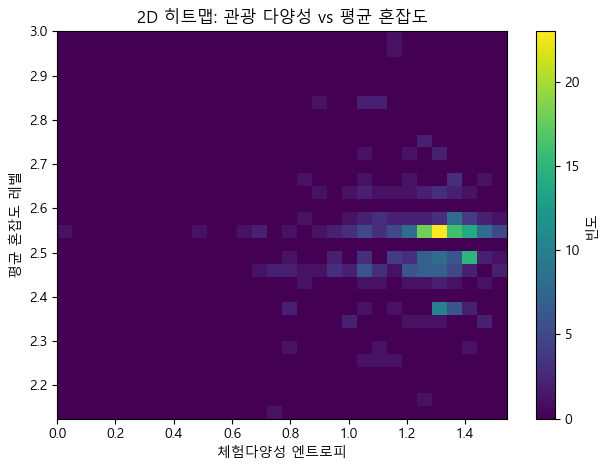

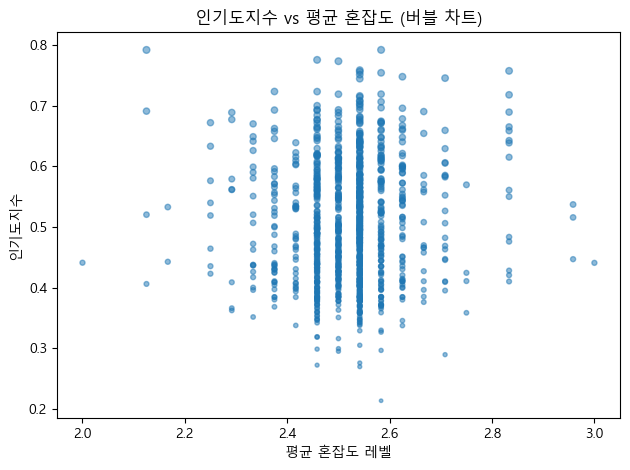

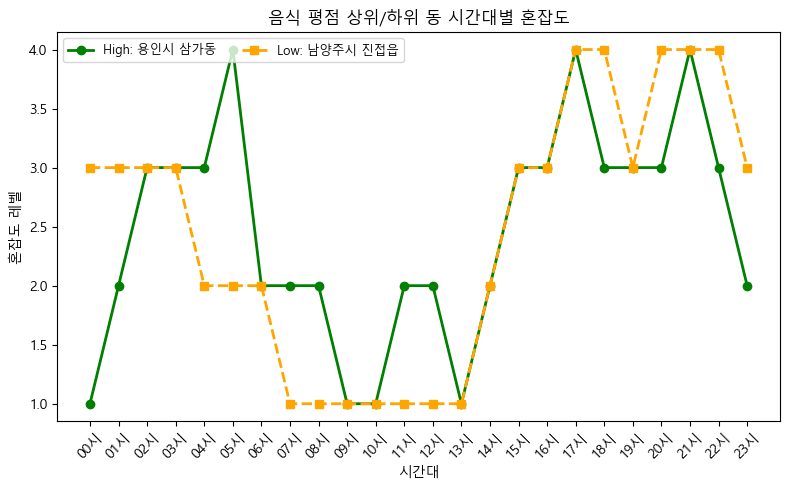

C:\Users\hyunj\AppData\Local\Temp\ipykernel_2636\3879288964.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([hb, lb], labels=['상위 10%','하위 10%'])


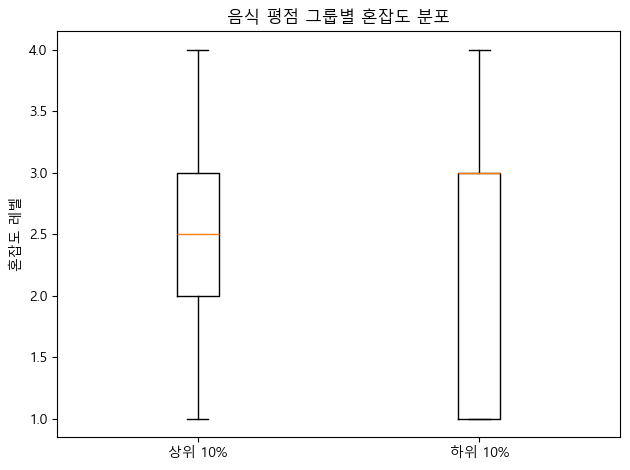

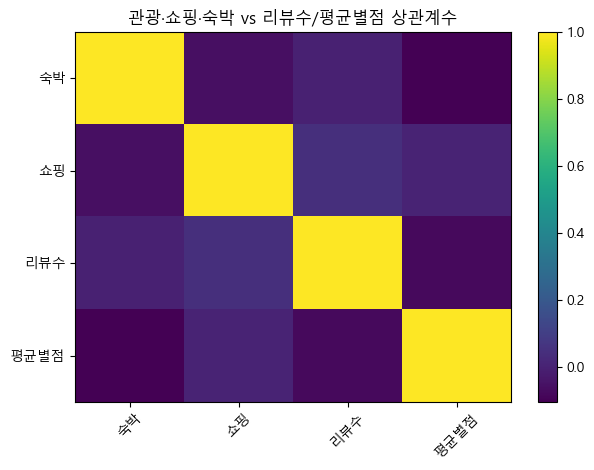

<Figure size 800x800 with 0 Axes>

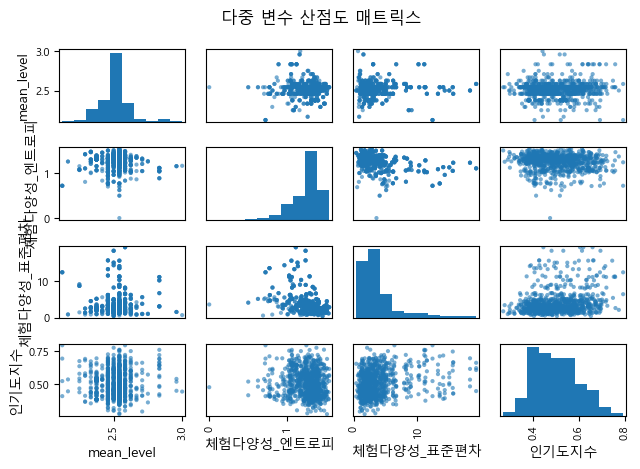

In [11]:
# 1) 산점도 + 추세선 (관광 다양성 vs 평균 혼잡도)
x = busy_tour['체험다양성_엔트로피']
y = busy_tour['mean_level']
if len(x) >= 2:
    coef = np.polyfit(x, y, 1)
    plt.figure()
    plt.scatter(x, y, alpha=0.6)
    plt.plot(x, np.polyval(coef, x), linestyle='--',
             label=f"y={coef[0]:.2f}x+{coef[1]:.2f}")
    plt.xlabel('체험다양성 엔트로피')
    plt.ylabel('평균 혼잡도 레벨')
    plt.title('관광 다양성 vs 평균 혼잡도')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 2) 2D 히트맵
plt.figure()
plt.hist2d(x, y, bins=30)
plt.colorbar(label='빈도')
plt.xlabel('체험다양성 엔트로피')
plt.ylabel('평균 혼잡도 레벨')
plt.title('2D 히트맵: 관광 다양성 vs 평균 혼잡도')
plt.tight_layout()
plt.show()

# 3) 버블 차트 (인기도지수 vs 평균 혼잡도)
plt.figure()
sizes = pop_busy['인기도지수'] * 30
plt.scatter(pop_busy['mean_level'], pop_busy['인기도지수'],
            s=sizes, alpha=0.5)
plt.xlabel('평균 혼잡도 레벨')
plt.ylabel('인기도지수')
plt.title('인기도지수 vs 평균 혼잡도 (버블 차트)')
plt.tight_layout()
plt.show()

# 4) “음식” 평점 상위/하위 그룹의 시간대별 혼잡도
# 1) final_level → 숫자 레벨 맵핑
mapping = {'여유':1, '보통':2, '붐빔':3, '매우 붐빔':4}
df_busy['level_num'] = df_busy['final_level'].map(mapping)

# 2) 음식 평균별점 상위/하위 10% key 추출
food = dong_cate_stats[['key','평균별점']]
high_th = food['평균별점'].quantile(0.9)
low_th  = food['평균별점'].quantile(0.1)
high_keys = food[food['평균별점']>=high_th]['key'].tolist()[:3]
low_keys  = food[food['평균별점']<=low_th ]['key'].tolist()[:3]

# 3) 색상 및 스타일 지정
high_colors = ['blue', 'green', 'purple']
low_colors  = ['orange', 'magenta', 'red']

# 4) 플롯
plt.figure(figsize=(8,5))

for idx, k in enumerate(high_keys):
    dfk = df_busy[df_busy['key']==k]
    if dfk.empty: 
        continue   # 매칭 안 되는 key 건너뛰기
    plt.plot(dfk['시간대'], dfk['level_num'],
             label=f'High: {k}',
             color=high_colors[idx], linewidth=2, marker='o')

for idx, k in enumerate(low_keys):
    dfk = df_busy[df_busy['key']==k]
    if dfk.empty:
        continue
    plt.plot(dfk['시간대'], dfk['level_num'],
             label=f'Low: {k}',
             color=low_colors[idx], linewidth=2, linestyle='--', marker='s')

plt.xticks(rotation=45)
plt.xlabel('시간대')
plt.ylabel('혼잡도 레벨')
plt.title('음식 평점 상위/하위 동 시간대별 혼잡도')
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# 5) 박스플롯 (상위10% vs 하위10%)
hb = df_busy[df_busy['key'].isin(high_keys)]['level_num']
lb = df_busy[df_busy['key'].isin(low_keys)]['level_num']
plt.figure()
plt.boxplot([hb, lb], labels=['상위 10%','하위 10%'])
plt.ylabel('혼잡도 레벨')
plt.title('음식 평점 그룹별 혼잡도 분포')
plt.tight_layout()
plt.show()

# 6) 상관계수 히트맵 (관광·쇼핑·숙박 vs 리뷰수/평균별점)
merged = pd.merge(df_tourism2, dong_cate_stats, on='key', how='inner')
corr_df = merged[['숙박','쇼핑','리뷰수','평균별점']].corr()
plt.figure()
plt.imshow(corr_df, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_df)), corr_df.columns, rotation=45)
plt.yticks(range(len(corr_df)), corr_df.index)
plt.title('관광·쇼핑·숙박 vs 리뷰수/평균별점 상관계수')
plt.tight_layout()
plt.show()

# 7) 다중 변수 산점도 매트릭스
pair_df = pd.merge(busy_tour, pop_busy[['key','인기도지수']], on='key', how='inner')
pair_vars = pair_df[['mean_level','체험다양성_엔트로피','체험다양성_표준편차','인기도지수']]
plt.figure(figsize=(8,8))
scatter_matrix(pair_vars, diagonal='hist', alpha=0.6)
plt.suptitle('다중 변수 산점도 매트릭스')
plt.tight_layout()
plt.show()

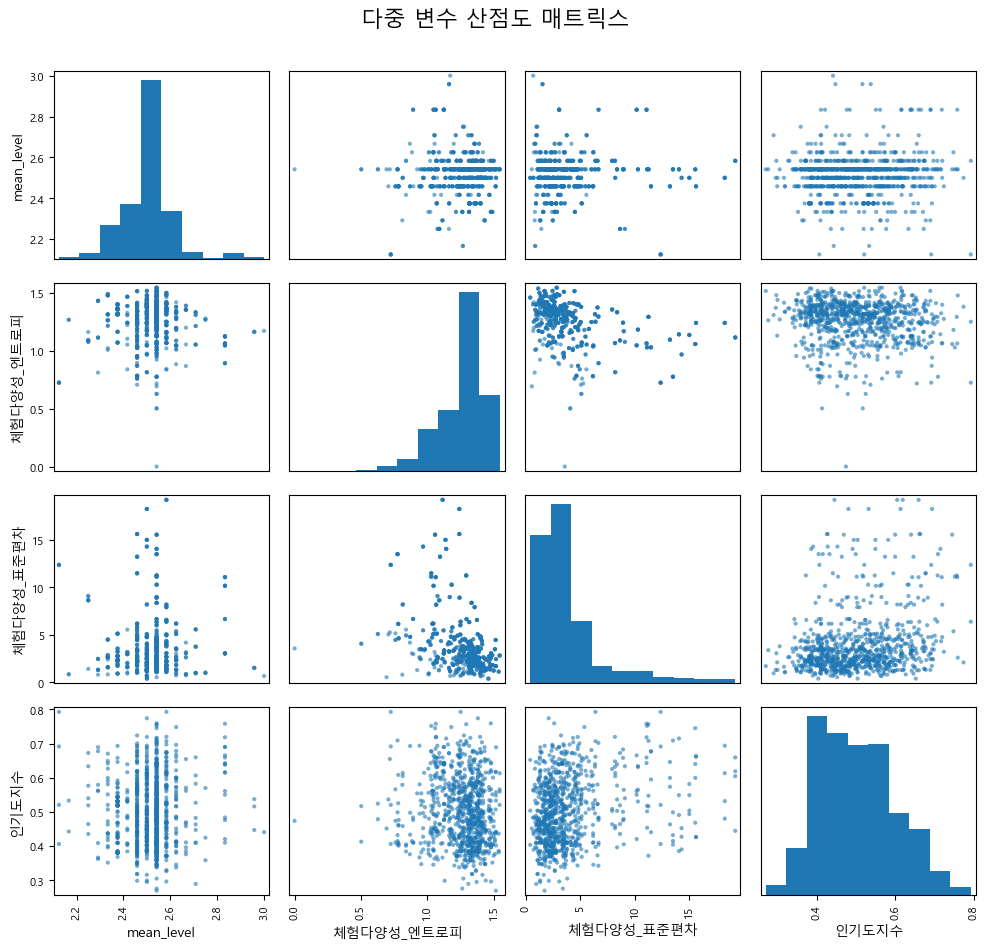

In [12]:
axes = scatter_matrix(pair_vars, diagonal='hist', alpha=0.6, figsize=(10, 10))
plt.suptitle('다중 변수 산점도 매트릭스', y=0.95, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()